АВТ-213 Гомзякова Софья

# Лабораторная работа №3

### Цель работы

Изучение методов классификации данных, реализованные в библиотеке Scikit-Learn, а также ознакомление с нейронными сетями с использованием библиотек TensorFlow и TensorBoard.

### Постановка задачи

1. Необходимо выбрать и подготовить датасет для классификации, затем построить классификационные модели с помощью пяти методов:

    a. Наивный Байесовский классификатор (GaussianNB, MultinomialNB, ComplementNB, BernoulliNB);

    b. Деревья решений (Decision Tree);

    c. Линейный дискриминантный анализ (Linear Discriminant Analysis);

    d. Метод опорных векторов (Support Vector Machines);

    e. Метод ближайших соседей (k-Nearest Neighbors);

2. Затем сравните качество работы классификаторов с помощью следующих метрик:

    a. Accuracy (точность),

    b. Precision (доля правильно классифицированных положительных примеров),

    c. Recall (чувствительность, доля верно найденных положительных примеров),

    d. F1-Score (среднее гармоническое precision и recall),

    e. Площадь под кривой ROC (AUC-ROC).

3. Настройте гиперпараметры каждого метода и проведите исследование влияния различных параметров на качество классификации.

4. Реализуйте и протестируйте нейронную сеть на TensorFlow, исследуйте эффект настройки гиперпараметров и визуализируйте процесс обучения с помощью инструмента TensorBoard.

## Описание датасета

Датасет для работы содержит информацию о 374 испытуемых и включает 13 признаков (столбцов):
- Person ID: уникальный идентификатор
- Gender: пол испытуемого (male/female)
- Age: возраст
- Occupation: должность (11 уникальных значений)
- Sleep Duration: время сна в часах
- Quality of Sleep: качество сна (оценка от 1 до 10)
- Physical Activity Level: уровень физической активности (минут в день)
- Stress Level: уровень стресса от 3 до 8
- BMI Category: категория по ИМТ (Normal, Overweight, Obese, Normal Weight)
- Blood Pressure: давление (25 уникальных значений)
- Heart Rate: пульс
- Daily Steps: шагов в день
- Sleep Disorder: расстройство сна (None при отсутствии расстройства, Sleep Apnea для апноэ, Insomnia - бессоница)

## Ход работы

### Импорты

In [235]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, OrdinalEncoder, TargetEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow.keras import layers, metrics as nnmetrics
import datetime

Чтение датасета, удаление идентификатора, установка целевой переменной и входных признаков, разбиение столбца Blood Pressure на два числовых, замена названия категории 'Normal Weight' в Sleep Disorder на 'Underwight' (опечатка в датасете).

Также в целевой переменной значение "None" (нет расстройства сна) было заменено на "No disorder" для конкретной обработки и лучшего отображения смысла.

In [236]:
df = pd.read_csv('Sleep_health_and_lifestyle_dataset.csv')
df = df.drop(['Person ID'], axis=1)

pressure_idx = df.columns.get_loc('Blood Pressure')
pressure_values = df['Blood Pressure']
df = df.drop('Blood Pressure', axis=1)
systolic = pressure_values.str.split('/').str[0].astype(int)
diastolic = pressure_values.str.split('/').str[1].astype(int)
df.insert(pressure_idx, 'Systolic BP', systolic)
df.insert(pressure_idx + 1, 'Diastolic BP', diastolic)

df['BMI Category'] = df['BMI Category'].replace('Normal Weight', 'Underweight')

target_names = ['Sleep Disorder']
feature_names = df.columns.drop(target_names)

df[target_names] = df[target_names].fillna('No disorder', axis=1)
df.info()
display(df.head())

target_classes = np.unique(df[target_names])

print("\nРазмер датасета:", df.shape)
print("Количество классов:", len(target_classes))
print("Названия классов:", target_classes)
print("Признаки:", feature_names)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 374 entries, 0 to 373
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Gender                   374 non-null    object 
 1   Age                      374 non-null    int64  
 2   Occupation               374 non-null    object 
 3   Sleep Duration           374 non-null    float64
 4   Quality of Sleep         374 non-null    int64  
 5   Physical Activity Level  374 non-null    int64  
 6   Stress Level             374 non-null    int64  
 7   BMI Category             374 non-null    object 
 8   Systolic BP              374 non-null    int64  
 9   Diastolic BP             374 non-null    int64  
 10  Heart Rate               374 non-null    int64  
 11  Daily Steps              374 non-null    int64  
 12  Sleep Disorder           374 non-null    object 
dtypes: float64(1), int64(8), object(4)
memory usage: 38.1+ KB


,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Systolic BP,Diastolic BP,Heart Rate,Daily Steps,Sleep Disorder
0,Male,27,Software Engineer,6.1,6,42,6,Overweight,126,83,77,4200,No disorder
1,Male,28,Doctor,6.2,6,60,8,Normal,125,80,75,10000,No disorder
2,Male,28,Doctor,6.2,6,60,8,Normal,125,80,75,10000,No disorder
3,Male,28,Sales Representative,5.9,4,30,8,Obese,140,90,85,3000,Sleep Apnea
4,Male,28,Sales Representative,5.9,4,30,8,Obese,140,90,85,3000,Sleep Apnea



Размер датасета: (374, 13)
Количество классов: 3
Названия классов: ['Insomnia' 'No disorder' 'Sleep Apnea']
Признаки: Index(['Gender', 'Age', 'Occupation', 'Sleep Duration', 'Quality of Sleep',
       'Physical Activity Level', 'Stress Level', 'BMI Category',
       'Systolic BP', 'Diastolic BP', 'Heart Rate', 'Daily Steps'],
      dtype='object')


Датасет содержит 374 значения и 13 переменных, из которых 4 категориальных и 9 числовых. Датасет не содержит пропущенных значений.

Данные в датасете разбиваются на 3 возможных класса - No disorder, Sleep Apnea и Insomnia.

Описательный анализ датасета:

In [237]:
numerical = ['Age', 'Sleep Duration', 'Quality of Sleep', 'Physical Activity Level', 'Stress Level',
             'Heart Rate', 'Daily Steps', 'Systolic BP', 'Diastolic BP']
categorical = df.columns.drop(numerical)

display(df.describe())

,Age,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,Systolic BP,Diastolic BP,Heart Rate,Daily Steps
count,374.000000,374.000000,374.000000,374.000000,374.000000,374.000000,374.000000,374.000000,374.000000
mean,42.184492,7.132086,7.312834,59.171123,5.385027,128.553476,84.649733,70.165775,6816.844920
std,8.673133,0.795657,1.196956,20.830804,1.774526,7.748118,6.161611,4.135676,1617.915679
min,27.000000,5.800000,4.000000,30.000000,3.000000,115.000000,75.000000,65.000000,3000.000000
25%,35.250000,6.400000,6.000000,45.000000,4.000000,125.000000,80.000000,68.000000,5600.000000
50%,43.000000,7.200000,7.000000,60.000000,5.000000,130.000000,85.000000,70.000000,7000.000000
75%,50.000000,7.800000,8.000000,75.000000,7.000000,135.000000,90.000000,72.000000,8000.000000
max,59.000000,8.500000,9.000000,90.000000,8.000000,142.000000,95.000000,86.000000,10000.000000


Распределения категорий для категориальных переменных в датасете:

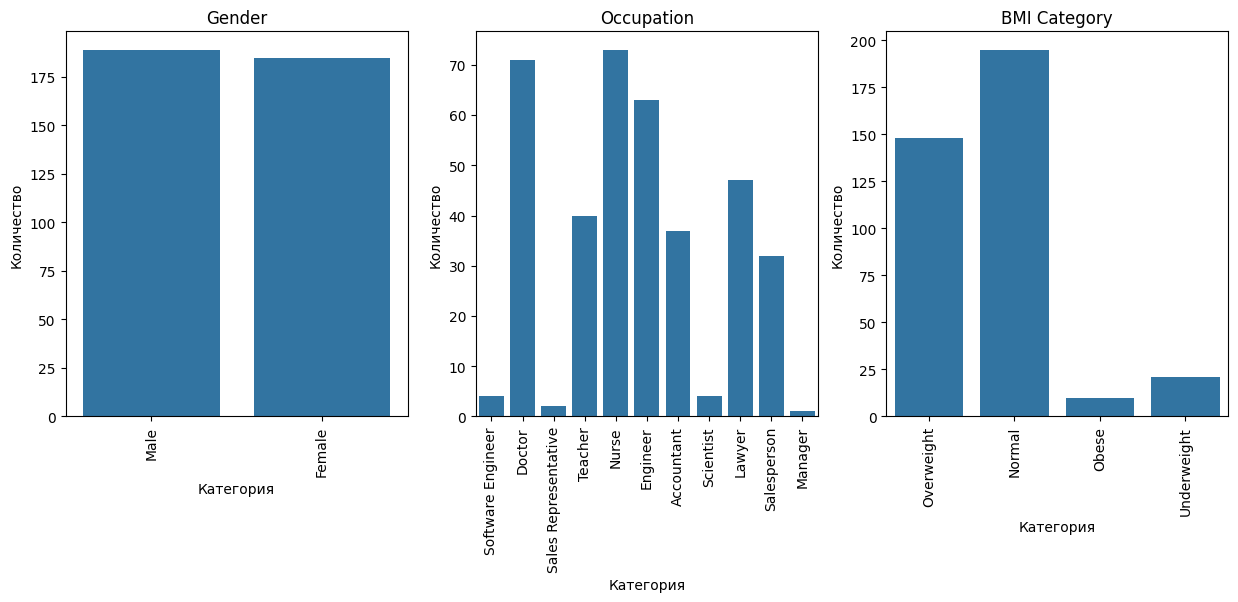

In [238]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

for i, col in enumerate(categorical.drop('Sleep Disorder')):
    sns.countplot(x=col, data=df, ax=axs[i])
    axs[i].set_title(col)
    axs[i].set_xlabel('Категория')
    axs[i].set_ylabel('Количество')
    axs[i].tick_params(axis='x', rotation=90)

Данные в категории Gender распределены примерно поровну, но в других категориальных переменных имеется сильный дисбаланс между количеством одних или других значений. Это может привести к переобучению модели на часто встречающихся категориях и плохому распределению категорий при разбиении на test-train.

Визуализация распределения классов целевой переменной Sleep Disorder:

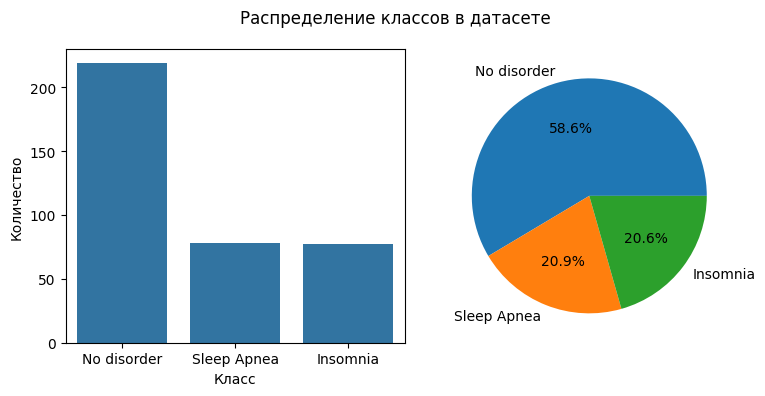

In [239]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4))

sns.countplot(x='Sleep Disorder', data=df, ax=axs[0])
axs[0].set_xlabel('Класс')
axs[0].set_ylabel('Количество')

counts = df[target_names].value_counts()
axs[1].pie(counts, labels=counts.index.get_level_values(0), autopct='%1.1f%%')

plt.suptitle('Распределение классов в датасете')
plt.tight_layout()
plt.show()

Как видно на диаграммах выше, категория 'No disorder' встречается почти в 3 раза больше двух других категорий. Модель может переобучаться для определения самого частого класса, и это будет влиять на ее точность, завышая Accuracy. Это необходимо учитывать при разбиении модели на train и test выборки и получении метрик.

Кодирование категориальных переменных Gender, Occupation, BMI Category и классов Sleep Disorder

In [240]:
encoders = {}
for feature in categorical:
    le = LabelEncoder()
    df[feature] = le.fit_transform(df[feature])
    encoders[feature] = le

display(df.head())
X = df[feature_names]
y = df[target_names]

,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Systolic BP,Diastolic BP,Heart Rate,Daily Steps,Sleep Disorder
0,1,27,9,6.1,6,42,6,2,126,83,77,4200,1
1,1,28,1,6.2,6,60,8,0,125,80,75,10000,1
2,1,28,1,6.2,6,60,8,0,125,80,75,10000,1
3,1,28,6,5.9,4,30,8,1,140,90,85,3000,2
4,1,28,6,5.9,4,30,8,1,140,90,85,3000,2


Разбиение на тренировочную и тестовую выборки (в тестовую выборку попадает 20% значений, параметр stratify сохраняет частоту каждого класса для обеих выборок) и масштабирование:

In [241]:
scaler = StandardScaler()

X = df.copy()[feature_names]
y = df[target_names]
X_train_orig, X_test_orig, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Размер тренировочной выборки: {X_train_orig.shape}")
print(f"Размер тестовой выборки: {X_test_orig.shape}")

X_train = X_train_orig.copy()
X_test = X_test_orig.copy()

X_train[numerical] = scaler.fit_transform(X_train_orig[numerical])
X_test[numerical] = scaler.fit_transform(X_test_orig[numerical])

display(X_train[numerical].describe().round(3))

Размер тренировочной выборки: (299, 12)
Размер тестовой выборки: (75, 12)


,Age,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,Heart Rate,Daily Steps,Systolic BP,Diastolic BP
count,299.000,299.000,299.000,299.000,299.000,299.000,299.000,299.000,299.000
mean,0.000,-0.000,0.000,-0.000,0.000,0.000,0.000,0.000,0.000
std,1.002,1.002,1.002,1.002,1.002,1.002,1.002,1.002,1.002
min,-1.781,-1.697,-2.810,-1.427,-1.362,-1.264,-2.401,-1.759,-1.564
25%,-0.731,-0.874,-1.116,-0.704,-0.792,-0.508,-0.541,-0.461,-0.754
50%,0.086,0.076,-0.269,0.018,-0.221,-0.003,0.079,0.187,0.055
75%,0.903,0.836,0.578,0.741,0.920,0.501,0.699,0.836,0.865
max,1.953,1.723,1.425,1.463,1.490,3.778,1.939,1.744,1.675


#### Создание и обучение моделей

Функция для моделирования и оценки результатов:

In [242]:
def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test) if hasattr(model, 'predict_proba') else None
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    auc_roc = roc_auc_score(y_test, y_proba, multi_class='ovo') if y_proba is not None else None
    
    confusion = confusion_matrix(y_test, y_pred)

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'auc_roc': auc_roc,
        'predictions': y_pred,
        'probabilities': y_proba,
        'matrix': confusion
    }

def show_matrix(confusion):
    plt.figure(figsize=(3, 3))
    sns.heatmap(confusion, annot=True, vmin=0, cmap='Greens')
    plt.title('Confusion matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

In [243]:
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

##### Обучение наивного Байесовского классификатора (с Гауссовским распределением)

Наивный Байесовский классификатор основан на применении теоремы Байеса с сильным (наивным) предположением о независимости признаков.

Формула Байеса для нахождения вероятности, что объект со значениями признаков Х относится к классу С:

$ P(C|X) = \frac{P(X|C)P(C)}{P(X)} $

Вероятность P(X) одинакова для всех классов и потому может быть опущена. В итоге алгоритм стремится к максимизации

$ C_{max} = \max{P(X|C)P(C)} $

Так НБК проводится по следующему алгоритму:
1. Вычисление вероятности класса P(C) и вероятности встретить в этом классе значения признаков Х (P(X|C)). Так как классификатор наивный, то выносится предположение о независимости признаков, и $ P(X|C) = P(x_1|C)P(x_2|C)...P(x_n|C) $.

$ P(x_i|C) = \frac{1}{\sqrt{2 \pi \sigma^2_C}}\exp{(-\frac{(x_i-\mu_C)^2}{2 \sigma^2_C})} $

где $ \mu_C $ и $ \sigma_C $ — это среднее и стандартное отклонения признака в классе C. Эти параметры оцениваются с помощью метода максимального правдоподобия по обучающим данным.

2. Сглаживание вероятностей для каждого признака, чтобы не допустить нулевой вероятности
3. Прогнозирование

Обучение Гауссовского НБК
Результаты: 
Accuracy:  0.92
Precision:  0.9331461988304094
Recall:  0.92
F1-Score:  0.9233548387096774
AUC-ROC:  0.9914141414141415
Confusion matrix:


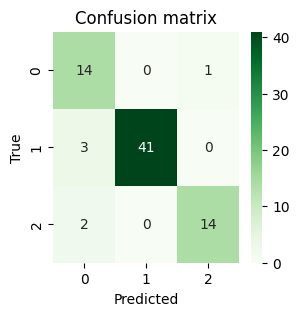

In [244]:
results = {}

nb_gauss = GaussianNB()
print('Обучение Гауссовского НБК')
results['GaussianNB'] = evaluate_model(nb_gauss, X_train_orig, X_test_orig, y_train, y_test)

print('Результаты: ')
print('Accuracy: ', results['GaussianNB']['accuracy'])
print('Precision: ', results['GaussianNB']['precision'])
print('Recall: ', results['GaussianNB']['recall'])
print('F1-Score: ', results['GaussianNB']['f1_score'])
print('AUC-ROC: ', results['GaussianNB']['auc_roc'])
print('Confusion matrix:')
show_matrix(results['GaussianNB']['matrix'])

##### Обучение дерева решений

Дерево решений - иерархическая структура из узлов и ветвей, где каждый узел - проверка условия, а ветви - возможные исходы проверки. Листовые узлы представляют собой результат классификации.

Алгоритм построения дерева решений:

1. Для корневого узла, содержащего всю выборку, рассчитываем индекс Джини или энтропию
2. Для каждого узла:
- Находятся все пороги разделения и разбиения по ним
- Вычисляется выигрыш от разделения:

$ Выигрыш = I_{род.узел} - (\frac{N_{пр.ветвь}}{N}I_{пр.ветвь} + \frac{N_{л.ветвь}}{N}I_{л.ветвь}) $,

где I() - мера неоднородности, индекс Джини или энтропия
- Выбирается разделение с наибольшим выигрышем
3. Шаг 2 повторяется, пока не выполнится условие остановки (максимальная глубина дерева, количество объектов в узле, неоднородность или другое)

Обучение дерева решений


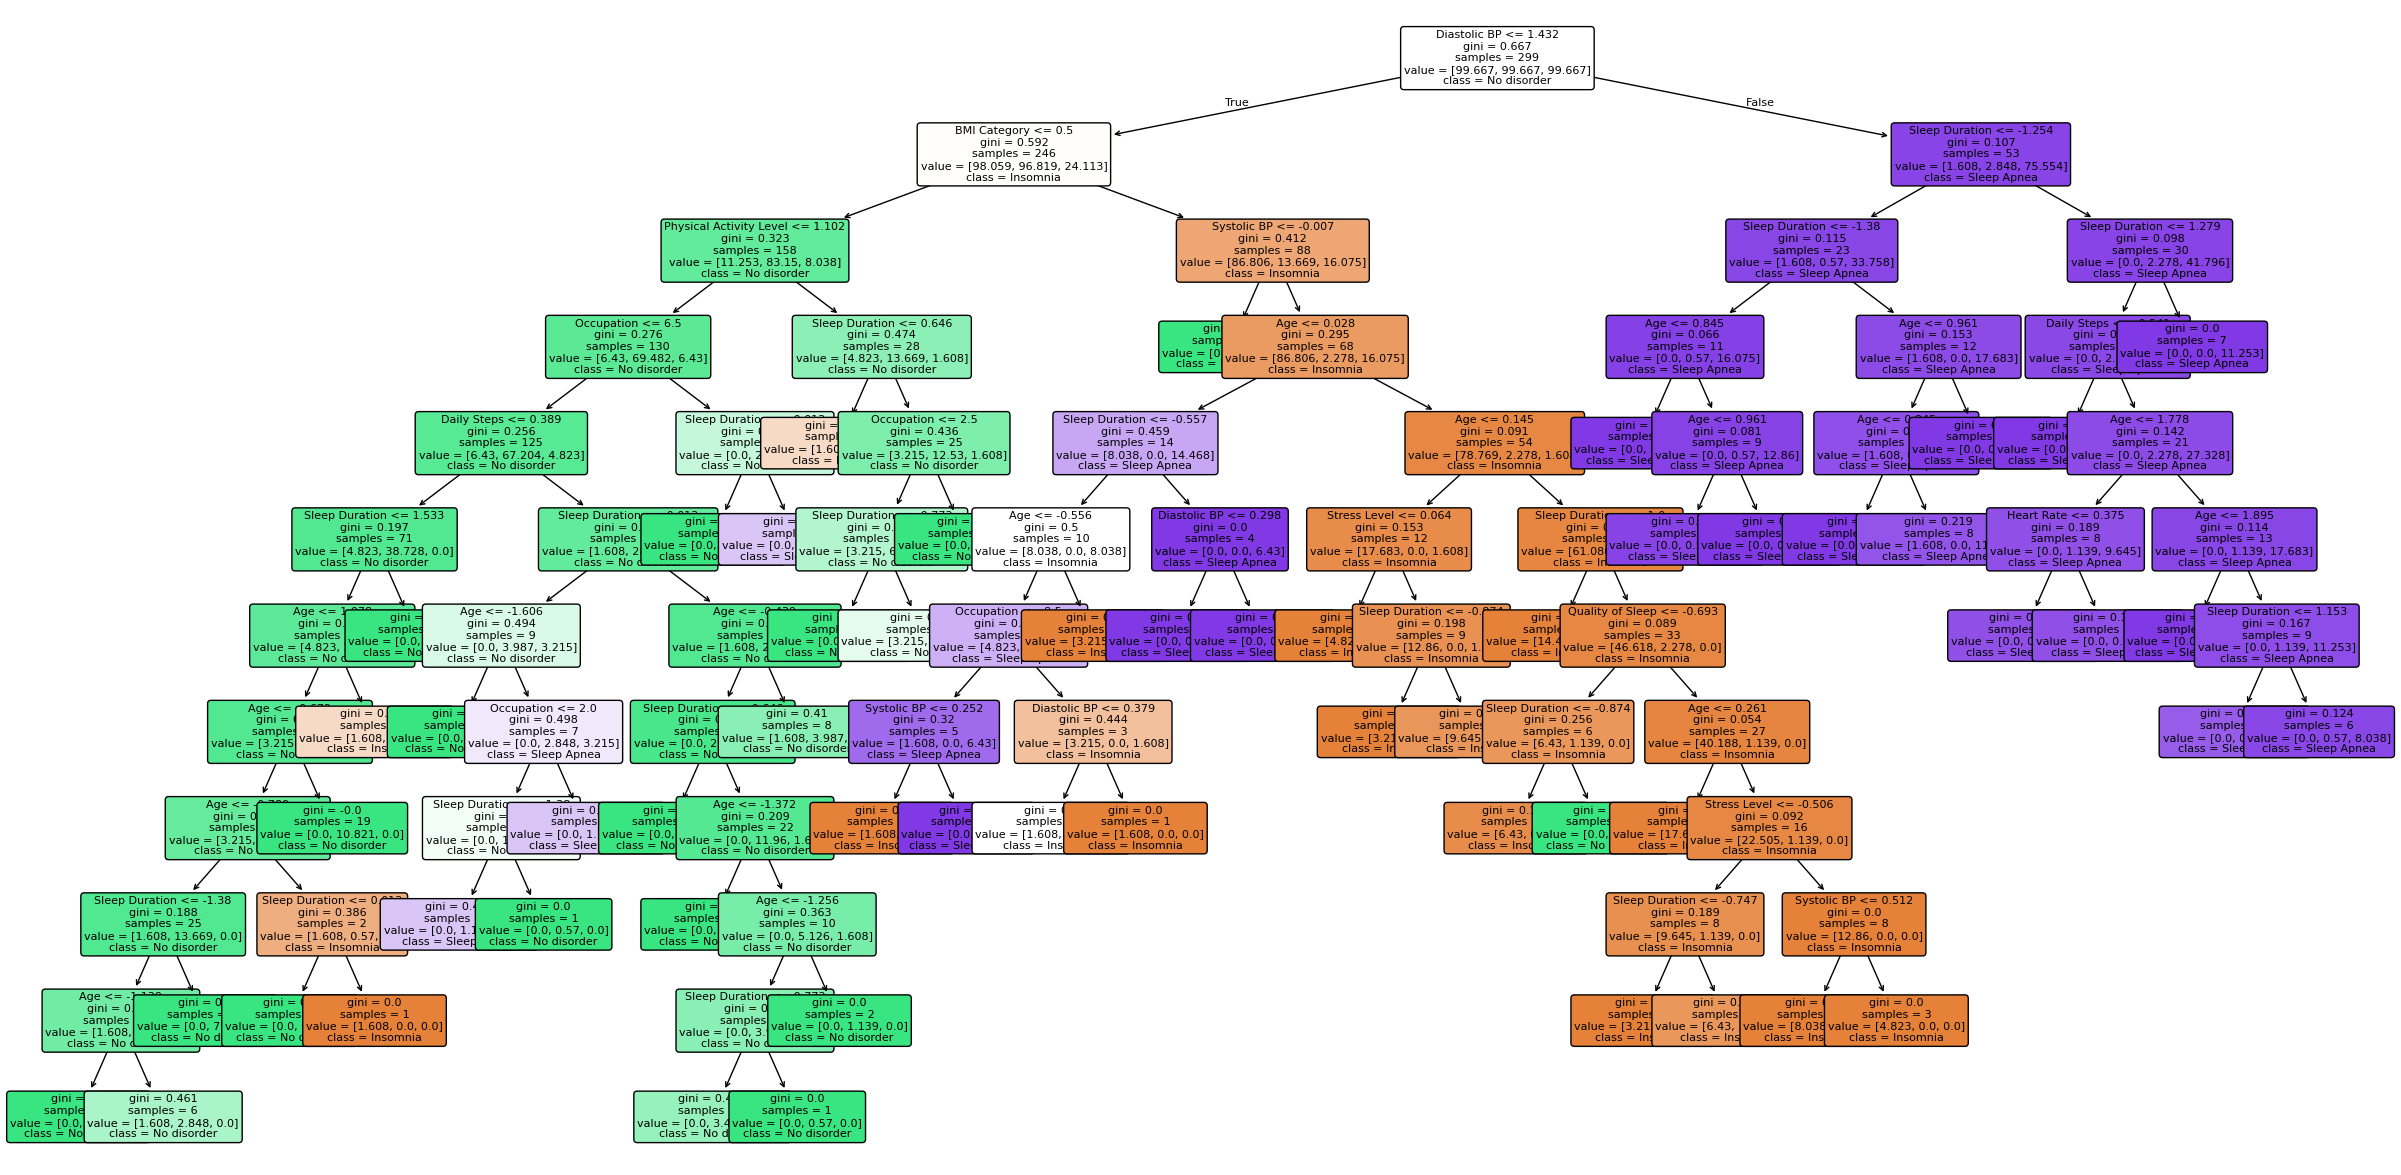

Результаты: 
Accuracy:  0.88
Precision:  0.8901355013550134
Recall:  0.88
F1-Score:  0.883065953654189
AUC-ROC:  0.9101325757575758
Confusion matrix:


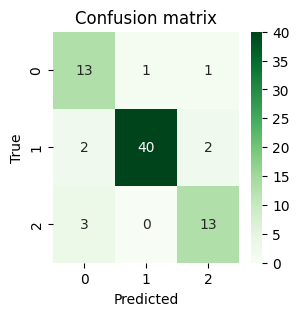

In [245]:
dtree = DecisionTreeClassifier(random_state=42, class_weight='balanced')
print('Обучение дерева решений')
results['Decision Tree'] = evaluate_model(dtree, X_train, X_test, y_train, y_test)

plt.figure(figsize=(30, 15))
plot_tree(
    dtree,
    filled=True,
    feature_names=X.columns,
    class_names=target_classes,
    rounded=True,
    fontsize=8
)
plt.show()

print('Результаты: ')
print('Accuracy: ', results['Decision Tree']['accuracy'])
print('Precision: ', results['Decision Tree']['precision'])
print('Recall: ', results['Decision Tree']['recall'])
print('F1-Score: ', results['Decision Tree']['f1_score'])
print('AUC-ROC: ', results['Decision Tree']['auc_roc'])
print('Confusion matrix:')
show_matrix(results['Decision Tree']['matrix'])

#### Модель линейного дискриминантного анализа

Линейный дискриминантный анализ - метод для поиска линейной комбинации признаков, которая описывает или разделяет классы, максимизируя отношение межклассовой дисперсии к внутриклассовой.

Алгоритм LDA:
1. Для каждого класса $ C_k $ находится центроид $ \mu_k = \frac{1}{n_k} \sum_{x_i \in C_k }{x_i} $ и общее среднее $ \mu = \frac{1}{n} \sum_{i=1}^n{x_i} $
2. Вычисляются матрицы рассеивания:
- Внутриклассовая: $ S_W = Σ_{k=1}^K Σ_{x_i ∈ C_k} (x_i - \mu_k)(x_i - \mu_k)^T $
- Межклассовая: $ Σ_{k=1}^K n_k (\mu_k - \mu)(\mu_k - \mu)^T $
- Общая: $ S_T = Σ_{i=1}^n (x_i - \mu)(x_i - \mu)^T = S_W + S_B $
3. Находится вектор w, максимизирующий критерий Фишера $ J(w) = (w^T S_B w) / (w^T S_W w) $
4. Находятся собственные значения и вектора для $ S_W^{-1} S_B $, выбираются первые K-1 собственных векторов, соответствующих наибольшим собственным значениям, которые составляют матрицу W - матрицу дискриминантных векторов
5. Проводится проекция данных: $ Z = XW $
6. Вычисляется правдоподобие для каждого класса $ p_k (z) = N (z | \mu_{k_{проекции}}, \sum{ков_{проекции}}) $
7. Находятся вероятности принадлежности к классу по Байесу: $ P(C_k | x) \approx \frac{n_k}{n} * p_k(z) $

Обучение модели линейного дискриминантного анализа...


Результаты: 
Accuracy:  0.88
Precision:  0.8858846872082166
Recall:  0.88
F1-Score:  0.8823254298423092
AUC-ROC:  0.9844854797979797
Confusion matrix:


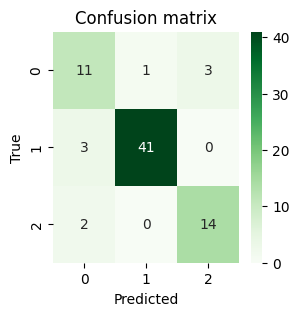

In [246]:
lda = LinearDiscriminantAnalysis()
print('Обучение модели линейного дискриминантного анализа...')
results['LDA'] = evaluate_model(lda, X_train, X_test, y_train, y_test)

print('Результаты: ')
print('Accuracy: ', results['LDA']['accuracy'])
print('Precision: ', results['LDA']['precision'])
print('Recall: ', results['LDA']['recall'])
print('F1-Score: ', results['LDA']['f1_score'])
print('AUC-ROC: ', results['LDA']['auc_roc'])
print('Confusion matrix:')
show_matrix(results['LDA']['matrix'])

#### Метод опорных векторов

Метод опорных векторов заключается в поиске гиперплоскости, максимально разделяющего классы с максимальным расстоянием между ними.

$ \langle \overrightarrow{w}, \overrightarrow{x} \rangle - b = 0 $ - уравнение гиперплоскости в пространстве $ R^n $,
где $ \overrightarrow{w} $ - вектор нормали к гиперплоскости, b - смещение, $\frac{b}{||\overrightarrow{w}||}$ - расстояние от гиперплоскости до начала координат. Данная плоскость делит пространство на 2 класса.

Метод опорных векторов с мягким отступом:
1. $ \frac{1}{2}||\overrightarrow{w}||^2 + C \sum_{i=1}^{n}{\xi_i} \rightarrow min $,

$ M_i((\overrightarrow{w}, b) ≥ 1 - \xi_i, \xi_i ≥ 0 $,

где $ M_i $ - отступ, $ \xi_i $ - переменные ослабления, С - параметр регуляризации (определяется кросс-валидацией).

2. Постановка задачи с применением ядер:
$ \begin{cases} 
-\mathcal{L}(\lambda) = -\sum_{i=1}^{\ell} \lambda_i + \frac{1}{2} \sum_{i=1}^{\ell} \sum_{j=1}^{\ell} \lambda_i \lambda_j y_i y_j K(\vec{x}_i, \vec{x}_j) \to \min_{\lambda} \\ 
0 \leq \lambda_i \leq C, \quad i = 1, \ldots, \ell \\ 
\sum_{i=1}^{\ell} \lambda_i y_i = 0 
\end{cases} $,

где $ \lambda_i $ - множители Лагранжа, $ K(x_i,x_j) $ - ядерная функция, $ y_i $ - класс

$ a(\vec{x}) = \text{sign} \left( \sum_{i=1}^{\ell} \lambda_i y_i K(\vec{x}_i, \vec{x}) - b \right) $, - линейный пороговый классификатор. Классификация новой точки x производится по знаку взвешенной суммы вкладов опорных векторов ($ \lambda_i $ > 0) через ядро K, с поправкой b.

Обучение модели с методом опорных векторов...
Результаты: 
Accuracy:  0.9333333333333333
Precision:  0.9374019607843138
Recall:  0.9333333333333333
F1-Score:  0.9347045852372184
AUC-ROC:  0.9910984848484848
Confusion matrix:


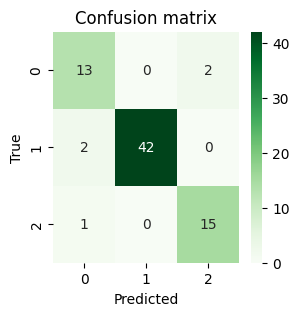

In [247]:
svm = SVC(probability=True, random_state=42, class_weight='balanced')
print('Обучение модели с методом опорных векторов...')
results['SVM'] = evaluate_model(svm, X_train, X_test, y_train, y_test)

print('Результаты: ')
print('Accuracy: ', results['SVM']['accuracy'])
print('Precision: ', results['SVM']['precision'])
print('Recall: ', results['SVM']['recall'])
print('F1-Score: ', results['SVM']['f1_score'])
print('AUC-ROC: ', results['SVM']['auc_roc'])
print('Confusion matrix:')
show_matrix(results['SVM']['matrix'])

#### K-Neighbors классификатор

Метод K-Nearest Neighbors (метод k-ближайших соседей) - метод классификации, основанный на определении, к какому классу относятся большинство из k соседей.

1. На обучающей выборке запоминается соответствие между объектами и классами, к которым они относятся
2. Для объектов тестовой выборки ищутся k ближайших объектов из обучающей и ищется наиболее частый класс, к которому они относятся.

Обучение модели с методом ближайших соседей...
Результаты: 
Accuracy:  0.9066666666666666
Precision:  0.9288888888888888
Recall:  0.9066666666666666
F1-Score:  0.9089036544850498
AUC-ROC:  0.9808001893939394
Confusion matrix:


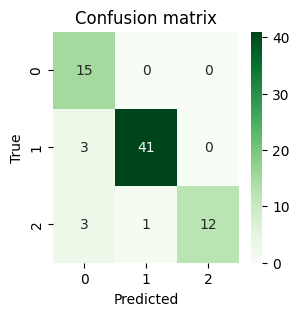

In [248]:
knn = KNeighborsClassifier()
print('Обучение модели с методом ближайших соседей...')
results['KNN'] = evaluate_model(knn, X_train, X_test, y_train, y_test)

print('Результаты: ')
print('Accuracy: ', results['KNN']['accuracy'])
print('Precision: ', results['KNN']['precision'])
print('Recall: ', results['KNN']['recall'])
print('F1-Score: ', results['KNN']['f1_score'])
print('AUC-ROC: ', results['KNN']['auc_roc'])
print('Confusion matrix:')
show_matrix(results['KNN']['matrix'])

Оценки для всех моделей:


Сравнение результатов классификации:


,Model,Accuracy,Precision,Recall,F1-Score,AUC-ROC
0,GaussianNB,0.9200,0.9331,0.9200,0.9234,0.9914
1,Decision Tree,0.8800,0.8901,0.8800,0.8831,0.9101
2,LDA,0.8800,0.8859,0.8800,0.8823,0.9845
3,SVM,0.9333,0.9374,0.9333,0.9347,0.9911
4,KNN,0.9067,0.9289,0.9067,0.9089,0.9808


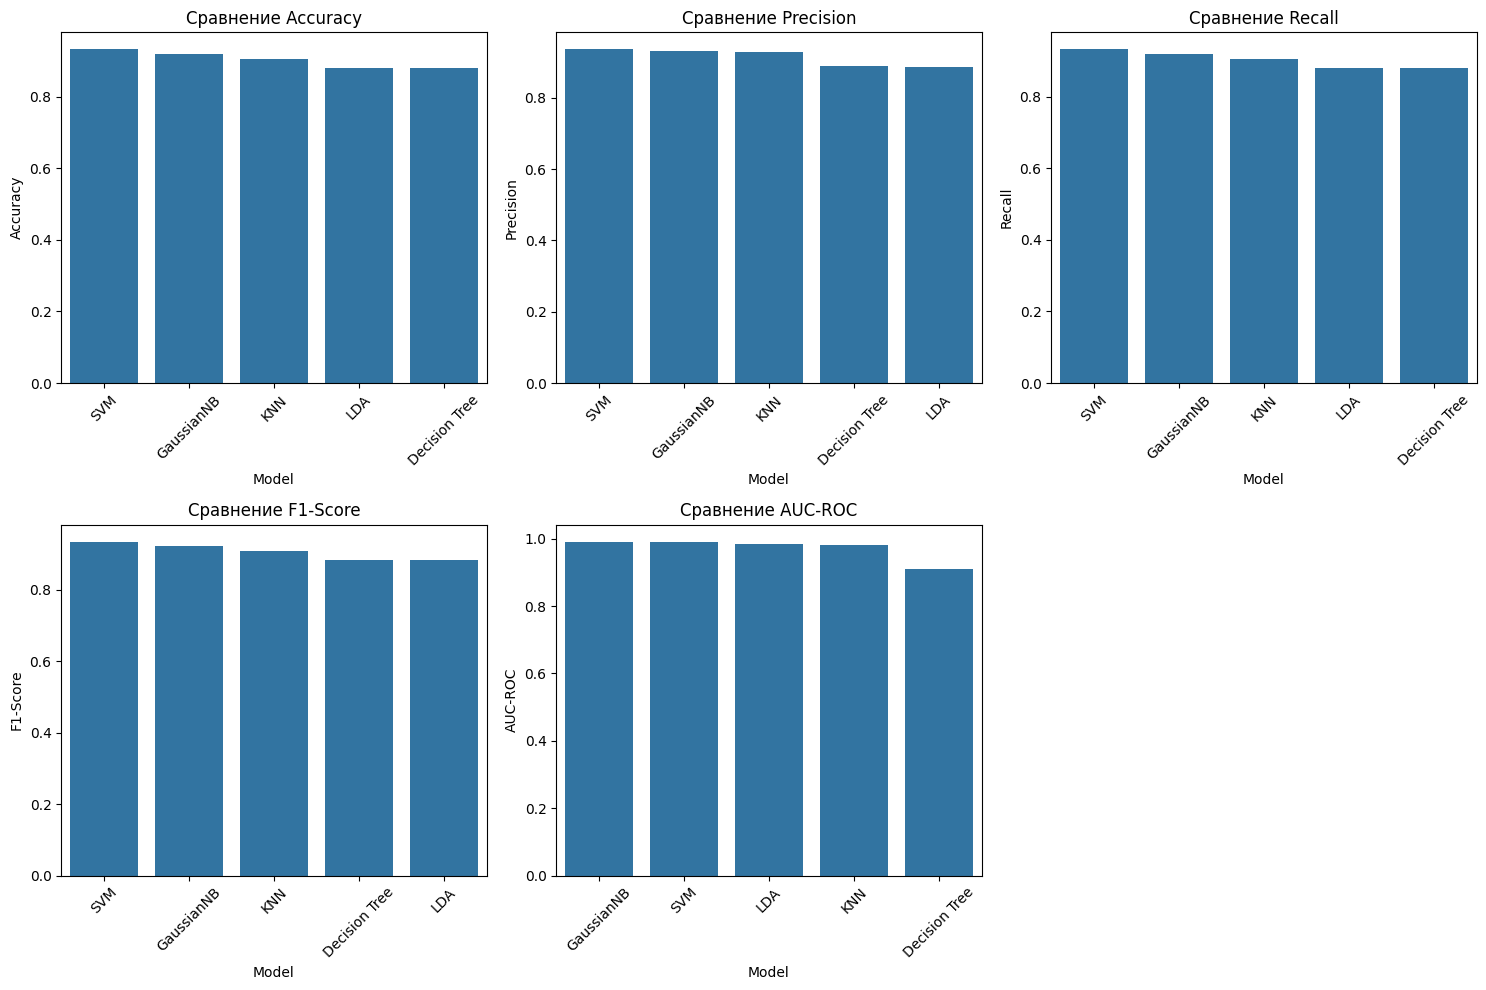

In [249]:
results_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [results[name]['accuracy'] for name in results.keys()],
    'Precision': [results[name]['precision'] for name in results.keys()],
    'Recall': [results[name]['recall'] for name in results.keys()],
    'F1-Score': [results[name]['f1_score'] for name in results.keys()],
    'AUC-ROC': [results[name]['auc_roc'] for name in results.keys()]
})

print("\nСравнение результатов классификации:")
display(results_df.round(4))

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC']
plt.title('Сравнение моделей по метрикам')

for i, metric in enumerate(metrics):
    sorted = results_df.sort_values(by=metric, ascending=False)
    sns.barplot(x='Model', y=metric, data=sorted, ax=axes[i], order=sorted['Model'])
    axes[i].set_title(f'Сравнение {metric}')
    axes[i].tick_params(axis='x', rotation=45)

if len(metrics) < len(axes):
    axes[-1].set_visible(False)

plt.tight_layout()
plt.show()

Все модели показали точность выше 0.88.

Наибольший показатель Accuracy (доля правильных ответов алгоритма) был получен у метода опорных векторов SVM (0.9333), наименьший - у LDA и дерева решений (0.88).

Лучший показатель точности Precision (точность, доля правильно определенных объектов класса) был у метода опорных векторов SVM (0.9374), наихудший - у LDA (0.8859).

Полученный показатель Recall (полнота, доля правильно найденных объектов класса) количественно повторяет Accuracy.

Лучший показатель F1-score (среднее гармоническое Precision и Recall) был так же получен у метода опорных векторов (0.9347), а худший - у LDA (0.8823).

Лучший показатель AUC-ROC (Area Under Curve, площадь под кривой ошибок) был у наивного байесовского классификатора (0.9914), а худший - у KNN (0.9808).

В целом наилучшие результаты были получены у метода опорных векторов SVM, а худшие - у дерева решений.

Создание сеток для кросс-валидации моделей с разными гиперпараметрами:

In [250]:
dtree_grid = {
        'max_depth': [3, 5, 7, 10, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'criterion': ['gini', 'entropy']
    }
LDA_grid = [
            {
                'solver': ['svd', 'lsqr', 'eigen'],
                'shrinkage': [None]
            },
            {
                'solver': ['lsqr', 'eigen'],
                'shrinkage': ['auto', 0.1, 0.5, 0.9]
            }
        ]
    
SVM_grid = {
        'C': [0.1, 1, 10, 100],
        'kernel': ['linear', 'rbf', 'poly'],
        'gamma': ['scale', 'auto', 0.1, 1]
    }
KNN_grid = {
        'n_neighbors': [3, 5, 7, 9, 11],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan', 'minkowski']
    }

best_models = {}
best_scores = {}

def test_params(model, grid, model_name):
    grid_search = GridSearchCV(
        model, grid, cv=5, scoring='accuracy', 
        n_jobs=-1, verbose=1
    )
    
    grid_search.fit(X_train, y_train)
    
    best_models[model_name] = grid_search.best_estimator_
    best_scores[model_name] = grid_search.best_score_
    
    print(f"Лучшие параметры для {model_name}: {grid_search.best_params_}")
    print(f"Лучшее значение точности: {grid_search.best_score_:.4f}\n")

test_params(DecisionTreeClassifier(random_state=42, class_weight='balanced'), dtree_grid, 'Decision Tree')
test_params(LinearDiscriminantAnalysis(), LDA_grid, 'LDA')
test_params(SVC(probability=True, random_state=42, class_weight='balanced'), SVM_grid, 'SVM')
test_params(KNeighborsClassifier(), KNN_grid, 'KNN')

Fitting 5 folds for each of 90 candidates, totalling 450 fits
Лучшие параметры для Decision Tree: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 2}
Лучшее значение точности: 0.8863

Fitting 5 folds for each of 11 candidates, totalling 55 fits
Лучшие параметры для LDA: {'shrinkage': 'auto', 'solver': 'lsqr'}
Лучшее значение точности: 0.8661

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Лучшие параметры для SVM: {'C': 1, 'gamma': 'auto', 'kernel': 'poly'}
Лучшее значение точности: 0.8997

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Лучшие параметры для KNN: {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'uniform'}
Лучшее значение точности: 0.8762



Были определены наилучшие параметры для моделей для достижения наибольшей точности.

Для дерева решений были получены следующие параметры (с точностью 0.8863):
- Лучший критерий неоднородности (criterion): gini (индекс Джини)
- Максимальная глубина (max_depth): 5
- Минимальное количество объектов в листовом узле (min_samples_leaf): 1
- Минимальное количество объектов в узле, при котором проводится разбиение (min_samples_split): 10

Для LDA было получено (с точностью 0.8828):
- Коэффициент сжатия (shrinkage): auto (автоматическое определение по лемме Ледуа-Вольфа)
- Метод решения (solver): lsqr (метод наименьших квадратов)

Для методая опорных векторов было получено: (с точностью 0.9097):
- Параметр регуляризации (C): 10
- Коэффициент ядра (gamma): scale ($ \frac{1}{n X.var()} $)
- Тип ядра (kernel): poly (полиномиальное)

Для метода k-ближайших соседей было получено: (с тончостью 0.8762):
- Метрика для рассчета расстояния (metric): manhattan (вычисление Manhattan distance)
- Количество соседей (n_neighbors): 3
- Веса (weights): uniform (одинаковые веса для всех точек)

Оценка моделей с улучшенными гиперпараметрами по результатам теста:

In [251]:
improved_results = {}

for name, model in best_models.items():
    print(f"Оценка улучшенной модели {name}...")
    improved_results[name] = evaluate_model(model, X_train, X_test, y_train, y_test)

comparison_df = pd.DataFrame({
    'Модель': list(best_models.keys()),
    'Начальная точность': [results[name]['accuracy'] for name in best_models.keys()],
    'Точность после улучшения': [improved_results[name]['accuracy'] for name in best_models.keys()],
    'Прирост': [improved_results[name]['accuracy'] - results[name]['accuracy'] for name in best_models.keys()]
})

print("\nСравнение до и после настройки гиперпараметров:")
display(comparison_df.round(4))

Оценка улучшенной модели Decision Tree...
Оценка улучшенной модели LDA...
Оценка улучшенной модели SVM...
Оценка улучшенной модели KNN...

Сравнение до и после настройки гиперпараметров:


,Модель,Начальная точность,Точность после улучшения,Прирост
0,Decision Tree,0.8800,0.9467,0.0667
1,LDA,0.8800,0.8933,0.0133
2,SVM,0.9333,0.9467,0.0133
3,KNN,0.9067,0.9467,0.0400


Все модели показали небольшой прирост точности после улучшения гиперпараметров. Наибольший прирост после настройки показал метод дерева решений, наименьший - LDA и SVM.

#### Исследование влияния гиперпараметров

Исследование влияния глубины дерева на точность классификатора Decision Tree:

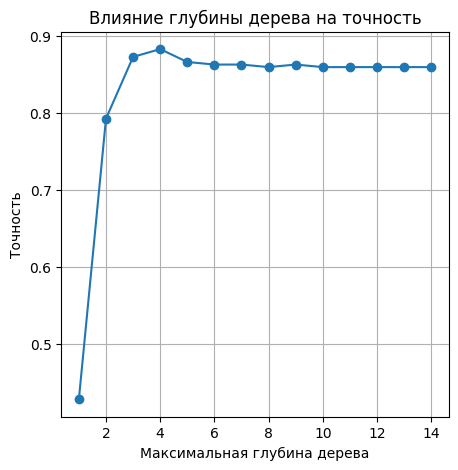

In [252]:
plt.figure(figsize=(5, 5))

depths = range(1, 15)
dt_scores = []
for depth in depths:
    dt = DecisionTreeClassifier(max_depth=depth, random_state=42, min_samples_split=10, class_weight='balanced')
    scores = cross_val_score(dt, X_train, y_train, cv=5)
    dt_scores.append(scores.mean())
    
plt.plot(depths, dt_scores, marker='o')
plt.xlabel('Максимальная глубина дерева')
plt.ylabel('Точность')
plt.title('Влияние глубины дерева на точность')
plt.grid(True)

plt.show()

По диаграмме видно, что наилучшая точность для дерева решений может быть получена при максимальной глубине дерева 4. После этого с увеличением глубины дерева точность уменьшается до значения глубины в 10 уровней, а далее перестает изменяться, так как фактическая глубина дерева не достигает максимального значения.

Исследование влияния количества соседей на точность K-Nearest Neighbours:

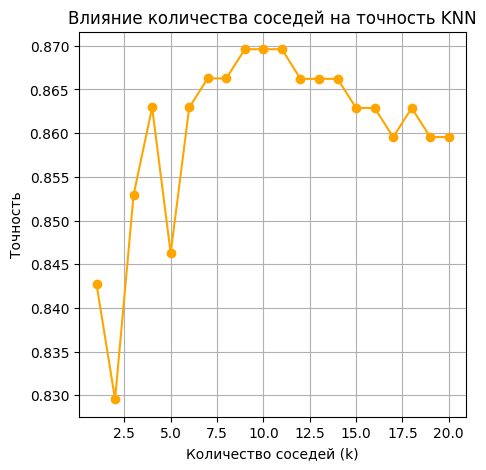

In [253]:
plt.figure(figsize=(5, 5))

neighbors = range(1, 21)
knn_scores = []
for n in neighbors:
    knn = KNeighborsClassifier(n_neighbors=n, metric='manhattan', weights='distance')
    scores = cross_val_score(knn, X_train, y_train, cv=5)
    knn_scores.append(scores.mean())
    
plt.plot(neighbors, knn_scores, marker='o', color='orange')
plt.xlabel('Количество соседей (k)')
plt.ylabel('Точность')
plt.title('Влияние количества соседей на точность KNN')
plt.grid(True)

plt.show()

Максимальная точность для KNN при изменении количества соседей достигается при значении 10. В начале диапазона точность достигает минимального значения при k=2 и k=5 и резко возрастает до максимального значения, после чего при увеличении значения точность имеет локальный максимум в k=14 и затем опускается.

Влияния параметра C на классификатор методом опорных векторов:

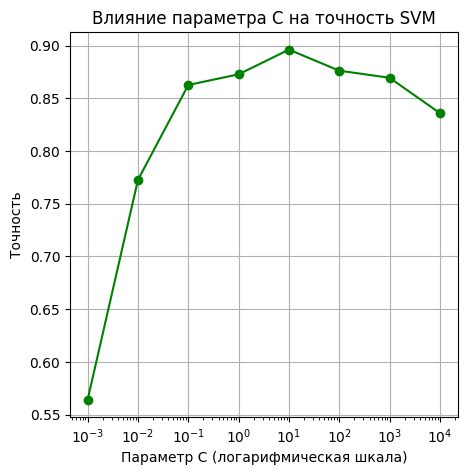

In [254]:
plt.figure(figsize=(5, 5))

c_values = [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
svm_scores = []
for c in c_values:
    svm = SVC(C=c, kernel='poly', random_state=42, class_weight='balanced')
    scores = cross_val_score(svm, X_train, y_train, cv=5)
    svm_scores.append(scores.mean())
    
plt.semilogx(c_values, svm_scores, marker='o', color='green')
plt.xlabel('Параметр C (логарифмическая шкала)')
plt.ylabel('Точность')
plt.title('Влияние параметра C на точность SVM')
plt.grid(True)

plt.show()

При настройке параметра регуляризации С у метода опорных векторов наилучшее значение достигается при значении 10.

Сравнение ядер для метода опорных векторов:

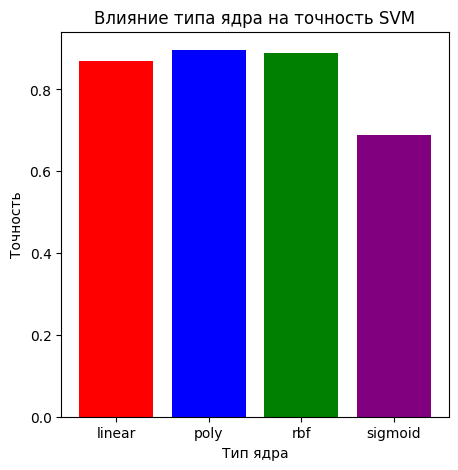

In [255]:
plt.figure(figsize=(5, 5))

kernels = ['linear', 'poly', 'rbf', 'sigmoid']
kernel_scores = []
for kernel in kernels:
    svm = SVC(kernel=kernel, C=10, random_state=42, class_weight='balanced')
    scores = cross_val_score(svm, X_train, y_train, cv=5)
    kernel_scores.append(scores.mean())
    
plt.bar(kernels, kernel_scores, color=['red', 'blue', 'green', 'purple'])
plt.xlabel('Тип ядра')
plt.ylabel('Точность')
plt.title('Влияние типа ядра на точность SVM')
    
plt.show()

Максимальная точность при различных типах ядра для метода опорных векторов была достигнута при полиномиальном типе, как и было получено при улучшениии.

### Нейронная сеть

Нейронная сеть - это вычислительная система, состоящая из множества взаимосвязанных простых процессоров (нейронов), организованных в слои.

Нейроны - базовая вычислительная единица, применяющая функцию активации к взвешенной сумме входных значений и добавляющая смещение (биас), чтобы определить выходной сигнал.

Связи (веса) - параметры сети, связывающие нейроны между слоями. Каждой связи присвоено значение-вес, показывающий силу передаваемого сигнала.

В последовательной (sequential) нейронной сети входной слой нейросети получает входные значения из датасета, обрабатывает их и передает на следующие, скрытые слои. На скрытых слоях происходит основная обработка данных и так до попадания на выходной слой, который формирует результат.

При обучении нейросеть подстраивает веса для минимизации ошибки.

Настройка TensorBoard:

In [256]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir, 
    histogram_freq=1,
    write_graph=True
)

Функция для создания нейронной сети с заданными параметрами:

In [257]:
def create_nn_model(hidden_layers=1, units=16, dropout_rate=0.3, learning_rate=0.001, activation='relu'):
    model = tf.keras.Sequential()
    
    model.add(layers.Input(shape=(X_train.shape[1],)))
    
    for _ in range(hidden_layers):
        model.add(layers.Dense(units, activation=activation))
        model.add(layers.Dropout(dropout_rate))
    
    model.add(layers.Dense(3, activation='softmax'))
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy'],
    )
    
    return model

Sequential создает последовательную модель нейронной сети. В первом, входном (Input) слое, содержится 12 нейронов, под каждый признак. Затем в модель добавляется заданное количество скрытых полносвязных Dense (все нейроны этого слоя связаны со всеми предыдущего слоя) слоев и некоторый процент значений, которые будут отбрасываться (Dropout, нужно для предотвращения переобучения). В конце создается выходной слой из трех (по числу целевых классов) нейронов.

Затем модель компилируется с заданными параметрами:
- optimizer: оптимизатор для обновления весов модели, Adam - адаптивная автоматическая настройка скорости обучения для каждого параметра
- loss: функция потерь, sparse_categorical_crossentropy - используется для многоклассовой классификации. Для каждого входного объекта модель предсказывает распределение вероятностей по всем классам.
- metrics: в процессе обучения выводится точность и f1-score для каждой эпохи.

Создание модели

In [258]:
model = create_nn_model(hidden_layers=1, units=16, dropout_rate=0.3, activation='relu')

print("Архитектура нейронной сети:")
model.summary()

Архитектура нейронной сети:


Model: "sequential_93"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_222 (Dense)               │ (None, 16)             │           208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_129 (Dropout)           │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_223 (Dense)               │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 259 (1.01 KB)

 Trainable params: 259 (1.01 KB)

 Non-trainable params: 0 (0.00 B)

Построенная последовательная модель состоит из трех слоев, входного (12 нейронов), скрытого (16 нейронов) и выходного (3 нейрона).

##### Обучение и оценка модели

Обучение проводится на протяжении 100 эпох (epochs) (данные прогоняются через модель 100 раз) и обновляет свои веса каждые 16 значений (размер пакета, batch_sizes).

In [259]:
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)

class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=16,
    validation_data=(X_test, y_test),
    callbacks=[tensorboard_callback],
    verbose=1, class_weight=class_weight_dict
)

nn_results = model.evaluate(X_test, y_test, verbose=0, return_dict=True)
test_loss = nn_results['loss']
test_accuracy = nn_results['accuracy']
print(f"\nТочность нейронной сети на тесте: {test_accuracy:.4f}, loss: {test_loss:.4f}")

Epoch 1/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.3177 - loss: 1.5281 - val_accuracy: 0.3600 - val_loss: 1.2034
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.3679 - loss: 1.3051 - val_accuracy: 0.4000 - val_loss: 1.0740
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3579 - loss: 1.2423 - val_accuracy: 0.5333 - val_loss: 0.9844
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.3278 - loss: 1.2696 - val_accuracy: 0.5867 - val_loss: 0.9025
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5351 - loss: 0.9745 - val_accuracy: 0.6133 - val_loss: 0.8487
Epoch 6/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5853 - loss: 0.8967 - val_accuracy: 0.6533 - val_loss: 0.8019
Epoch 7/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5251 - loss: 0.9739 - val_accuracy: 0.6800 - val_loss: 0.7562
Epoch 8/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6120 - loss: 0.8258 - val_accuracy: 0.7067 

После 100 эпох точность модели составила 0.8796, потери 0.5118, для валидационных метрик - точность 0.92 и потери 0.2836. Это показывает, что в данном случае модель лучше сработала на тестовых данных, чем на тренировочных.

Визуализация процесса обучения

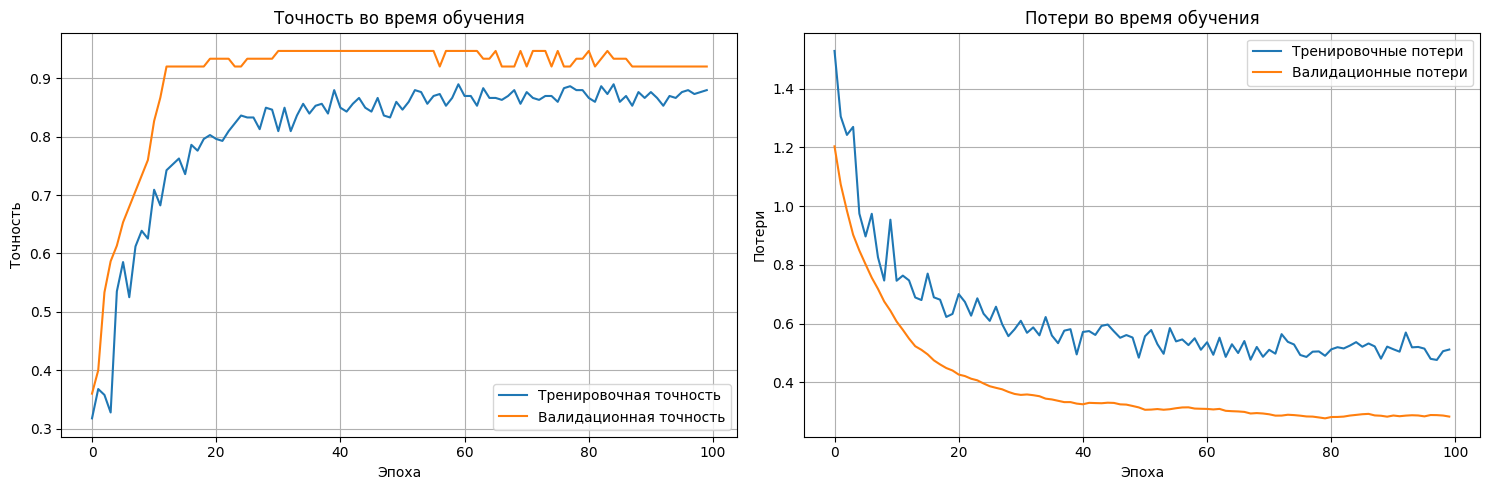

In [260]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
ax1.plot(history.history['accuracy'], label='Тренировочная точность')
ax1.plot(history.history['val_accuracy'], label='Валидационная точность')
ax1.set_xlabel('Эпоха')
ax1.set_ylabel('Точность')
ax1.set_title('Точность во время обучения')
ax1.legend()
ax1.grid(True)
    
ax2.plot(history.history['loss'], label='Тренировочные потери')
ax2.plot(history.history['val_loss'], label='Валидационные потери')
ax2.set_xlabel('Эпоха')
ax2.set_ylabel('Потери')
ax2.set_title('Потери во время обучения')
ax2.legend()
ax2.grid(True)
    
plt.tight_layout()
plt.show()

#### Визуализация на TensorBoard

In [264]:
%reload_ext tensorboard
%tensorboard --logdir logs/fit

Reusing TensorBoard on port 6007 (pid 14072), started 0:06:38 ago. (Use '!kill 14072' to kill it.)

Получившиеся изображения на TensorBoard:

![Гистограмма смещения](tensorboard_shots/bias_hist_2025-12-03_17-50-15.png)

На данной гистограмме изображены смещения слоев во время обучения модели. По горизонтальной оси показывается значение параметра, вглубину - номер эпохи, а по вертикали - частота для каждого интервала значений.

По данной диаграмме можно наблюдать, что c каждой эпохой коэффициенты "расползаются" (уменьшается частота интервалов, но увеличивается разброс между минимальными и максимальными смещениями). Это может говорить о переобучении или плохой сходимости.

![Гистограмма весов](tensorboard_shots/kernel_hist_2025-12-03_17-57-41.png)

На данной гистограмме изображены веса во время обучения модели. По горизонтальной оси показывается значение параметра, вглубину - номер эпохи, а по вертикали - частота для каждого интервала значений.

![Зависимость точности модели от эпохи](tensorboard_shots/epoch_acc_2025-12-03_17-51-06.png)
![Зависимость потерь модели от эпохи](tensorboard_shots/epoch_loss_2025-12-03_17-52-16.png)

На данних гистограммах показаны зависимости точности и потерь модели от эпохи. Можно наблюдать, что метрики при валидации лучше метрик при тренировке (точность выше и потери меньше), что показывает, что модель хорошо работает на новых данных. Также можно наблюдать, что обе величины перестают сильно изменяться после 50 эпохи, следовательно, можно уменьшить количество эпох обучения без существенных потерь в точности.

![Зависимость точности модели от шага](tensorboard_shots/eval_acc_vs_iter_2025-12-03_17-53-08.png)
![Зависимость потерь модели от шага](tensorboard_shots/eval_loss_vs_iter_2025-12-03_17-56-57.png)

На данных гистограммах показана информация аналогичная предыдущим, но для каждого шага (каждая эпоха включает в себя несколько шагов в зависимости от того, на сколько пакетов разбиваются данные).

На первом графике точность сначала перестает изменяться на шагах 600-1000 (на уровне примерно 0.95), а затем начинает колебаться, оставаясь в пределах 0.92-0.95. На графике потерь на этом же диапазоне потери медленно уменьшаются, а на последних примерно 600 шагах остается примерно одинаковыми.

Влияние архитектуры сети

In [261]:
architectures = [
    {'hidden_layers': 1, 'units': 16, 'dropout': 0.3, 'epochs': 50, 'batches': 16, 'activation': 'relu'},
    {'hidden_layers': 1, 'units': 16, 'dropout': 0.3, 'epochs': 50, 'batches': 16, 'activation': 'sigmoid'},
    {'hidden_layers': 1, 'units': 16, 'dropout': 0.3, 'epochs': 50, 'batches': 16, 'activation': 'softmax'},
    {'hidden_layers': 1, 'units': 16, 'dropout': 0.3, 'epochs': 50, 'batches': 16, 'activation': 'tanh'},

    {'hidden_layers': 4, 'units': 16, 'dropout': 0.3, 'epochs': 50, 'batches': 16, 'activation': 'relu'},
    {'hidden_layers': 8, 'units': 16, 'dropout': 0.3, 'epochs': 50, 'batches': 16, 'activation': 'relu'},

    {'hidden_layers': 1, 'units': 4, 'dropout': 0.3, 'epochs': 50, 'batches': 16, 'activation': 'relu'},
    {'hidden_layers': 1, 'units': 64, 'dropout': 0.3, 'epochs': 50, 'batches': 16, 'activation': 'relu'},

    {'hidden_layers': 1, 'units': 16, 'dropout': 0, 'epochs': 50, 'batches': 16, 'activation': 'relu'},
    {'hidden_layers': 1, 'units': 16, 'dropout': 0.5, 'epochs': 50, 'batches': 16, 'activation': 'relu'},

    {'hidden_layers': 1, 'units': 16, 'dropout': 0.3, 'epochs': 10, 'batches': 16, 'activation': 'relu'},
    {'hidden_layers': 1, 'units': 16, 'dropout': 0.3, 'epochs': 200, 'batches': 16, 'activation': 'relu'},

    {'hidden_layers': 1, 'units': 16, 'dropout': 0.3, 'epochs': 50, 'batches': 4, 'activation': 'relu'},
    {'hidden_layers': 1, 'units': 16, 'dropout': 0.3, 'epochs': 50, 'batches': 64, 'activation': 'relu'},
]


results = []
for i, arch in enumerate(architectures):
    print(f"Обучение архитектуры {i + 1}: {arch}")
    
    model = create_nn_model(
        hidden_layers=arch['hidden_layers'],
        units=arch['units'],
        dropout_rate=arch['dropout']
    )
        
    history = model.fit(
        X_train, y_train,
        epochs=arch['epochs'],
        batch_size=arch['batches'],
        validation_data=(X_test, y_test),
        verbose=0, class_weight=class_weight_dict
    )
        
    grid_results = model.evaluate(X_test, y_test, verbose=0, return_dict=True)
    test_loss = grid_results['loss']
    test_accuracy = grid_results['accuracy']
        
    results.append({
        'Layers': arch['hidden_layers'],
        'Units': arch['units'],
        'Droupout': arch['dropout'],
        'Epochs': arch['epochs'],
        'Batch sizes': arch['batches'],
        'Activation': arch['activation'],
        'Test loss': test_loss,
        'Final Train Acc.': history.history['accuracy'][-1],
        'Final Val Acc.': history.history['val_accuracy'][-1]
    })
    
nn_results = pd.DataFrame(results)
print("\nСравнение архитектур нейронных сетей:")
display(nn_results.round(4))

Обучение архитектуры 1: {'hidden_layers': 1, 'units': 16, 'dropout': 0.3, 'epochs': 50, 'batches': 16, 'activation': 'relu'}
Обучение архитектуры 2: {'hidden_layers': 1, 'units': 16, 'dropout': 0.3, 'epochs': 50, 'batches': 16, 'activation': 'sigmoid'}
Обучение архитектуры 3: {'hidden_layers': 1, 'units': 16, 'dropout': 0.3, 'epochs': 50, 'batches': 16, 'activation': 'softmax'}
Обучение архитектуры 4: {'hidden_layers': 1, 'units': 16, 'dropout': 0.3, 'epochs': 50, 'batches': 16, 'activation': 'tanh'}
Обучение архитектуры 5: {'hidden_layers': 4, 'units': 16, 'dropout': 0.3, 'epochs': 50, 'batches': 16, 'activation': 'relu'}
Обучение архитектуры 6: {'hidden_layers': 8, 'units': 16, 'dropout': 0.3, 'epochs': 50, 'batches': 16, 'activation': 'relu'}
Обучение архитектуры 7: {'hidden_layers': 1, 'units': 4, 'dropout': 0.3, 'epochs': 50, 'batches': 16, 'activation': 'relu'}
Обучение архитектуры 8: {'hidden_layers': 1, 'units': 64, 'dropout': 0.3, 'epochs': 50, 'batches': 16, 'activation': 're

,Layers,Units,Droupout,Epochs,Batch sizes,Activation,Test loss,Final Train Acc.,Final Val Acc.
0,1,16,0.3,50,16,relu,0.3836,0.8562,0.9200
1,1,16,0.3,50,16,sigmoid,0.3312,0.8361,0.9067
2,1,16,0.3,50,16,softmax,0.3320,0.8428,0.9067
3,1,16,0.3,50,16,tanh,0.3406,0.8428,0.8933
4,4,16,0.3,50,16,relu,0.4511,0.7559,0.9067
5,8,16,0.3,50,16,relu,0.5523,0.7793,0.8000
6,1,4,0.3,50,16,relu,0.6000,0.5886,0.7333
7,1,64,0.3,50,16,relu,0.2418,0.8930,0.9467
8,1,16,0.0,50,16,relu,0.2509,0.8930,0.9200
9,1,16,0.5,50,16,relu,0.3701,0.7559,0.9333


При протестированных различных архитектурах были получены следующие выводы:
- Из четырех протестированных функций активации (ReLU, sigmoid, softmax и tanh) лучшая точность была получена на функции relu, худшая - на tanh.
- При тестировании различного количества скрытых слоев (1, 4 и 8) лучшая точность была достигнута при 1 слое, затем начала падать.
- При тестировании различного количества нейронов в скрытых слоях (4, 16 и 64) лучшая точность была достигнута при 64 нейронах.
- При тестировании различного Droupout rate (0 (значения не отбрасываются), 0.3 и 0.5) лучшая точность вышла при 0.5.
- При различном количестве эпох (10, 50 и 200) лучшая точность была при при 200 эпохах.
- При различных размерах пакетов (4, 16 и 64) лучшая точность была при размере пакета 16.

#### Финальный результат сравнения всех моделей

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step

Финальное сравнение всех методов:
            Model  Accuracy  Precision  Recall  F1-Score  AUC-ROC
0      GaussianNB    0.9200     0.9331  0.9200    0.9234   0.9914
1   Decision Tree    0.8800     0.8901  0.8800    0.8831   0.9101
2             LDA    0.8800     0.8859  0.8800    0.8823   0.9845
3             SVM    0.9333     0.9374  0.9333    0.9347   0.9911
4             KNN    0.9067     0.9289  0.9067    0.9089   0.9808
5  Neural Network    0.9200     0.9331  0.9200    0.9234   0.9654


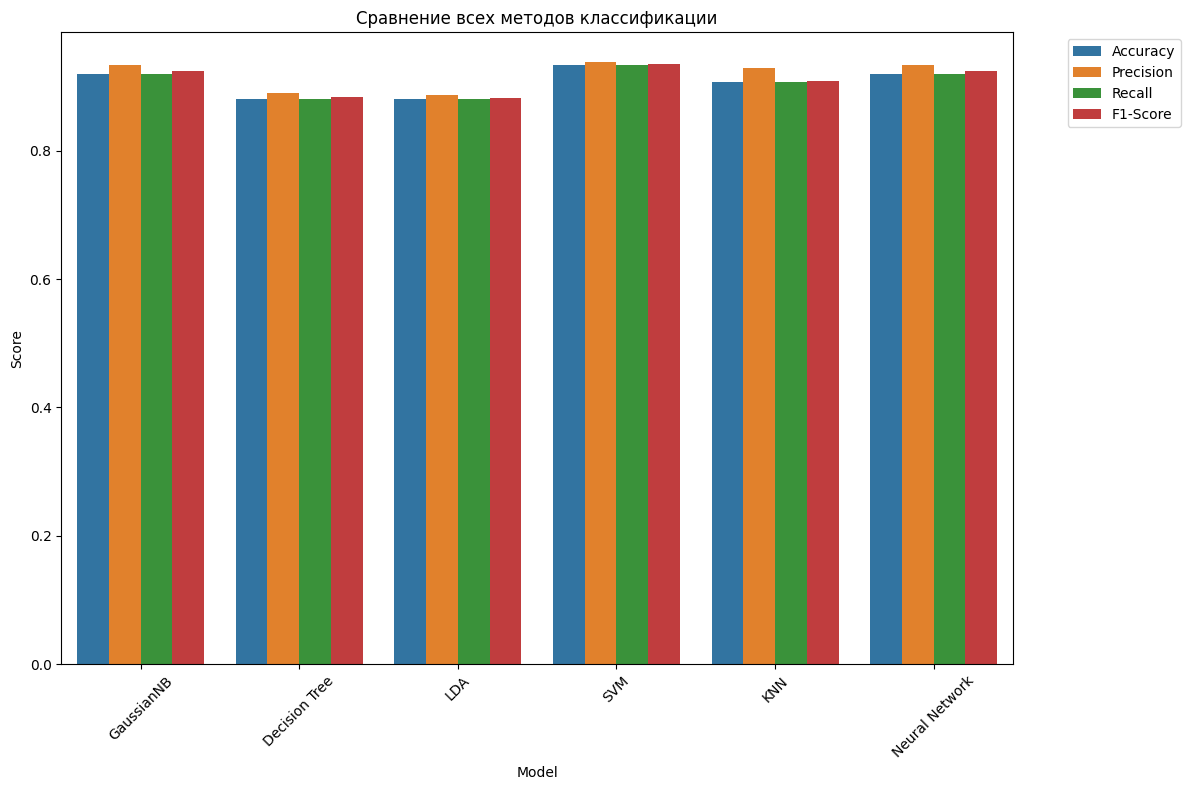

In [262]:
final_comparison = results_df.copy()

predicted = model.predict(X_test)
y_pred = np.argmax(predicted, axis=1)

nn_row = {
    'Model': 'Neural Network',
    'Accuracy': test_accuracy,
    'Precision': precision_score(y_test, y_pred, average='weighted'),
    'Recall': recall_score(y_test, y_pred, average='weighted'),
    'F1-Score': f1_score(y_test, y_pred, average='weighted'),
    'AUC-ROC': roc_auc_score(y_test, predicted, multi_class='ovo')
}

final_comparison = pd.concat([final_comparison, pd.DataFrame([nn_row])], ignore_index=True)

print("\nФинальное сравнение всех методов:")
print(final_comparison.round(4))

plt.figure(figsize=(12, 8))
metrics_comparison = final_comparison.melt(id_vars='Model', 
                                         value_vars=['Accuracy', 'Precision', 'Recall', 'F1-Score'],
                                         var_name='Metric', value_name='Score')

sns.barplot(x='Model', y='Score', hue='Metric', data=metrics_comparison)
plt.title('Сравнение всех методов классификации')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

Лучшие характеристики были показаны у модели на основе метода опорных векторов. Чуть меньшее качество было показано наивным байесовским классификатором и нейросетью. Худшее качество было показано LDA и деревом решений.

GaussianNB представляет собой быстрый алгоритм и показывает почти самый лучший результат, поэтому его можно назвать оптимальным с точки зрения точности и скорости.

Дерево решений и LDA показали гораздо худшие результаты, чем другие модели, из-за чего можно заключить, что либо были плохо настроены параметры моделей, либо данные методы хуже применимы к данному датасету.

Нейросеть не показала существенного прироста точности при повышении затрат на вычисления.

## Заключение

В ходе лабораторной работы было проведено сравнение шести методов машинного обучения для решения задачи классификации на выбранном датасете. Наилучшие результаты продемонстрировал метод опорных векторов (SVM), показавший максимальные значения accuracy, recall и f1-score. Похожую эффективность также проявили наивный байесовский классификатор (GaussianNB) и нейросеть. Это позволяет сделать вывод, что для данной задачи хорошо подходят модели для разделения нелинейных зависимостей, что и было получено SVM с подобранным ядром, а также устойчивостью к шумам в данных.

В то же время модели линейного дискриминантного анализа (LDA) и дерева решений показали значительно более низкое качество классификации. Это может указывать на то, что линейные предположения LDA недостаточно хорошо описывают структуру данных, а дерево решений, вероятно, столкнулось с проблемой переобучения. Нейронная сеть не обеспечила существенного прироста в точности по сравнению с другими методами, что свидетельствует о достаточности более простых и менее ресурсоемких моделей для данного набора данных.

Таким образом, исследование показало, что для рассматриваемой задачи оптимальным решением с точки зрения баланса точности и вычислительной эффективности является метод опорных векторов или гауссовский наивный байесовский классификатор. Нейронные сети, обладая высоким потенциалом, не продемонстрировали в данном случае значительных преимуществ.